In [2]:
# from google.colab import files
# uploaded = files.upload()


In [3]:
import zipfile
import os

with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall("data")


In [4]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
#BEZ SKALOWANIa
train_data = datasets.ImageFolder(
    root="data/data/split/train",
    transform=transforms.ToTensor()
)

test_data = datasets.ImageFolder(
    root="data/data/split/test",
)

image, label = train_data[0]
print(image, label)
print(image.shape)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]) 0
torch.Size([3, 208, 176])


In [7]:
#Z skalowaniem

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels= 1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_data = datasets.ImageFolder(
    root="data/data/split/train",
    transform=transform
)

test_data = datasets.ImageFolder(
    root="data/data/split/test",
    transform= transform
)

image, label = train_data[0]
print(image, label)
print(image.shape)

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]) 0
torch.Size([1, 128, 128])


In [8]:
names_of_classes = train_data.classes

In [9]:
train_data.class_to_idx

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

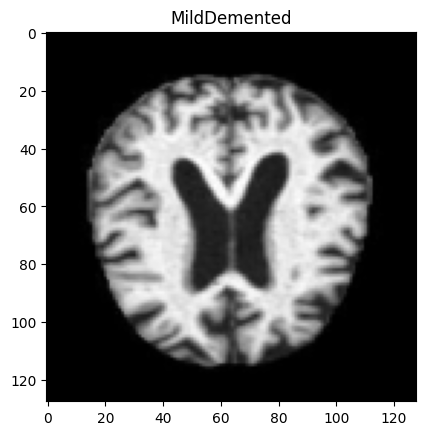

In [10]:
image, label = train_data[0]
plt.title(label)
plt.title(names_of_classes[label])
plt.imshow(image.squeeze(), cmap='gray')

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_data,
    batch_size = 32,
    shuffle = True
)

test_dataloader = DataLoader(
    test_data,
    batch_size = 32,
    shuffle = False
)

print(f"Length of train dataloader: {len(train_dataloader)}")
print(f"Length of test dataloader: {len(test_dataloader)}")

image, label = train_data[0]
print(image.shape)
print(label)

image_batch, label_batch = next(iter(train_dataloader))
print(image_batch.shape)
print(label_batch)

Length of train dataloader: 160
Length of test dataloader: 41
torch.Size([1, 128, 128])
0
torch.Size([32, 1, 128, 128])
tensor([2, 1, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 0, 2, 0, 3, 0, 2, 2,
        0, 0, 3, 2, 2, 3, 2, 3])


Shape before flattening: torch.Size([1, 128, 128]) -> [color_channels, height, width]


Shape after flattening: torch.Size([1, 16384]) -> [color_channels, height*width]

## MODEL **0**

In [12]:
from torch import nn
class ModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layer1(x)


In [13]:
modelV0 = ModelV0(
    input_shape=1 * 128 * 128,
    hidden_units=32,
    output_shape=len(names_of_classes)
)
modelV0

ModelV0(
  (layer1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelV0.parameters(), lr=0.01)

In [15]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


    from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [16]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    modelV0.train()
    y_pred = modelV0(X)

    loss = loss_fn(y_pred, y)

    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 20 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)

  test_loss, test_acc = 0, 0
  modelV0.eval()
  with torch.inference_mode():
      for X, y in test_dataloader:
          test_pred = modelV0(X)

          test_loss += loss_fn(test_pred, y)
          test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

      test_loss /= len(test_dataloader)

      test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(modelV0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/5119 samples
Looked at 640/5119 samples
Looked at 1280/5119 samples
Looked at 1920/5119 samples
Looked at 2560/5119 samples
Looked at 3200/5119 samples
Looked at 3840/5119 samples
Looked at 4480/5119 samples

Train loss: 1.08951 | Test loss: 0.93864, Test acc: 57.24%

Epoch: 1
-------
Looked at 0/5119 samples
Looked at 640/5119 samples
Looked at 1280/5119 samples
Looked at 1920/5119 samples
Looked at 2560/5119 samples
Looked at 3200/5119 samples
Looked at 3840/5119 samples
Looked at 4480/5119 samples

Train loss: 0.95067 | Test loss: 0.91172, Test acc: 51.91%

Epoch: 2
-------
Looked at 0/5119 samples
Looked at 640/5119 samples
Looked at 1280/5119 samples
Looked at 1920/5119 samples
Looked at 2560/5119 samples
Looked at 3200/5119 samples
Looked at 3840/5119 samples
Looked at 4480/5119 samples

Train loss: 0.90885 | Test loss: 0.87851, Test acc: 52.97%

Train time on cpu: 20.690 seconds


In [17]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):

    model.to(device)
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

results_of_model0 = eval_model(model=modelV0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
results_of_model0

{'model_name': 'ModelV0',
 'model_loss': 0.8785109519958496,
 'model_acc': 52.97256097560975}

# MODEL **1**

In [18]:
class ModelV1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
      super().__init__()
      self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=input_shape, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=output_shape),
          nn.ReLU()
      )

  def forward(self, x: torch.Tensor):
    return self.layers(x)

In [19]:
torch.manual_seed(42)
modelV1 = ModelV1(
    input_shape=128 * 128,
    hidden_units=32,
    output_shape=len(names_of_classes)
).to(device)

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelV1.parameters(), lr=0.1e-3)

In [21]:
def train(model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device):

    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      train_loss += loss
      train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test(model: nn.Module,
         data_loader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         accuracy_fn,
         device: torch.device = device
         ):

  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_test_pred = model(X)

      test_loss += loss_fn(y_test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=y_test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [22]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train(data_loader=train_dataloader,
        model=modelV1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test(model=modelV1,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.30657 | Train accuracy: 49.58%
Test loss: 1.27606 | Test accuracy: 48.78%

Epoch: 1
---------
Train loss: 1.25300 | Train accuracy: 50.01%
Test loss: 1.25475 | Test accuracy: 48.78%

Epoch: 2
---------
Train loss: 1.23899 | Train accuracy: 50.01%
Test loss: 1.24816 | Test accuracy: 48.78%

Train time on cuda: 19.815 seconds


In [23]:
results_of_model1 = eval_model(model=modelV1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn)
results_of_model1

{'model_name': 'ModelV1',
 'model_loss': 1.2481647729873657,
 'model_acc': 48.78048780487805}

# MODEL **2**

In [24]:
class ModelV2CNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
     super().__init__()
     self.block1 = nn.Sequential(
         nn.Conv2d(in_channels=input_shape,
                   out_channels=hidden_units,
                   kernel_size=3,
                   stride=1,
                   padding=1),
         nn.ReLU(),
         nn.Conv2d(in_channels=hidden_units,
                   out_channels=hidden_units,
                   kernel_size=3,
                   stride=1,
                   padding=1),
         nn.ReLU(),
         nn.MaxPool2d(kernel_size=2, stride=2)
     )
     self.block2 = nn.Sequential(
         nn.Conv2d(in_channels=hidden_units,
                   out_channels=hidden_units,
                   kernel_size=3,
                   stride=1,
                   padding=1),
         nn.ReLU(),
         nn.Conv2d(in_channels=hidden_units,
                   out_channels=hidden_units,
                   kernel_size=3,
                   stride=1,
                   padding=1),
         nn.ReLU(),
         nn.MaxPool2d(kernel_size=2, stride=2)
     )
     self.classifier = nn.Sequential(
         nn.Flatten(),
         nn.Linear(in_features=hidden_units*32*32,
                   out_features= output_shape)
     )

  def forward(self, x: torch.Tensor):
    x = self.block1(x)
    print(x.shape)
    x = self.block2(x)
    print(x.shape)
    x = self.classifier(x)
    print(x.shape)
    return x

torch.manual_seed(42)
modelV2 = ModelV2CNN(input_shape=1,
                     hidden_units=64,
                     output_shape=len(names_of_classes)).to(device)

modelV2

ModelV2CNN(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=4, bias=True)
  )
)

In [25]:
from collections import Counter
import torch

# Załóżmy, że masz listę etykiet train_labels
train_labels = [label for _, label in train_data]  # lub jak to masz

class_counts = Counter(train_labels)
print(class_counts)

# Obliczamy wagi odwrotne do częstości:
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[i] for i in range(len(class_counts))]

class_weights_tensor = torch.tensor(class_weights).float().to(device)
print("Class weights:", class_weights_tensor)


Counter({2: 2560, 3: 1792, 0: 716, 1: 51})
Class weights: tensor([  7.1494, 100.3726,   1.9996,   2.8566], device='cuda:0')


In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelV2.parameters(), lr=0.01)

In [27]:
for images, labels in train_dataloader:
    images = images.to(device)
    outputs = modelV2(images)
    break


torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])


In [28]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 20
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train(data_loader=train_dataloader,
        model=modelV2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test(data_loader=test_dataloader,
        model=modelV2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([31, 64, 64, 64])
torch.Size([31, 64, 32, 32])
torch.Size([31, 4])
Train loss: 0.55857 | Train accuracy: 77.26%
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
tor

In [29]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):

    model.to(device)
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}



In [30]:
results_of_model2 = eval_model(
    model=modelV2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
results_of_model2

torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 4])
torch.Size([32, 64, 64, 64])
torch.Size([32, 64, 32, 32])
torch.

{'model_name': 'ModelV2CNN',
 'model_loss': 0.14661914110183716,
 'model_acc': 95.27439024390245}

In [31]:
from collections import Counter
print(Counter([label for _, label in train_data]))


Counter({2: 2560, 3: 1792, 0: 716, 1: 51})
